Source of the Data: https://www.kaggle.com/datasets/ninopadilla13/employee-churn 

We choose regression to predict the Satisfaction of employees

In [40]:
#packages needed
import pandas as pd
import sklearn
from sklearn import linear_model
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
import matplotlib.pyplot as plt

First, we clean up the data a bit and observe the patterns

In [5]:
employee_churn = pd.read_csv(r'employee_churn.csv')
employee_churn.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


We observed many categorical data so I transformed salary and status to digits and kept department as it is 

In [6]:
#cleaning the data
employee_churn['salary'] = employee_churn['salary'].replace({'low': 1, 'medium': 2, 'high': 3}) #projecting categorical data to numerical
employee_churn['status'] = employee_churn['status'].replace({'Left': 1, 'Employed': 0})
employee_churn = employee_churn.fillna(0)
employee_churn.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
count,14249.000000,14249.000000,14249.000000,14249.000000,14249.000000,14249.000000,14249.000000,14249.000000,14249.000000
mean,199.795775,0.144431,0.641229,3.773809,0.021054,1.592884,0.613403,0.238052,3.452804
std,50.998714,0.351539,0.276165,1.253126,0.143570,0.634788,0.258417,0.425906,1.503517
min,49.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,155.000000,0.000000,0.521363,3.000000,0.000000,1.000000,0.442048,0.000000,3.000000
50%,199.000000,0.000000,0.682387,4.000000,0.000000,2.000000,0.647489,0.000000,3.000000
75%,245.000000,0.000000,0.856517,5.000000,0.000000,2.000000,0.822709,0.000000,4.000000
max,310.000000,1.000000,1.000000,7.000000,1.000000,3.000000,1.000000,1.000000,10.000000


For the ones that shows as NaN, I filled it in as 0 rather than deleting it but if we delete the row that has NaN, we won't be left with much data. I understand that there is a risk associated with it so later on I will perform standarization where we transform all columns to have a mean of 0 and a standard deviation of 1

By looking at the distribution of the data, we can see that there are some binomial attributes, filed_complaint, recently promoted, status, and others follow normal distribution, such as average monthly hours.

Linear Regression

Did you analyze multi-collinearity? -yes
Have you done the T-Test and F-Test? -yes
Have you calculated an R-square? -yes

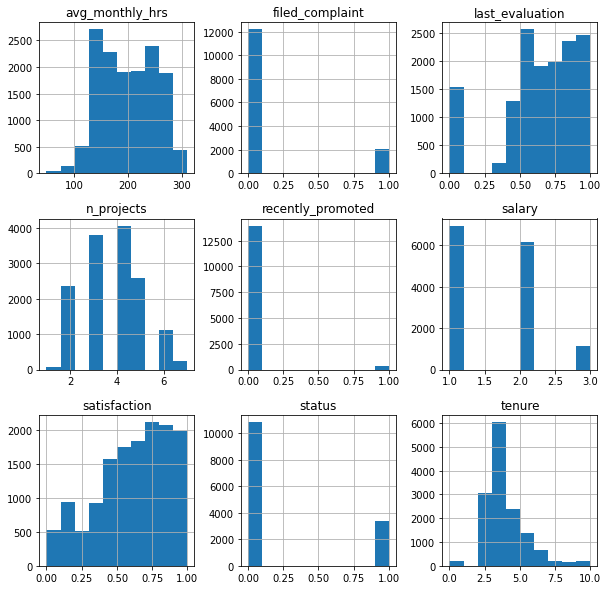

In [7]:
#basic visualization
employee_churn.hist(figsize=(10, 10));

A collinearity is a special case when two or more variables are exactly correlated. It's important to check the assumptions first before go ahead to analysis. 

In [13]:
#check colinearity
def compute_vif(considered_features):
    
    X = employee_churn[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [14]:
# features to consider removing
considered_features = ['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary','status', 'tenure']

# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

<ipython-input-13-eafe787ee3ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
3,n_projects,1.330754
0,avg_monthly_hrs,1.293888
2,last_evaluation,1.205846
7,tenure,1.146642
6,status,1.083577
5,salary,1.037698
1,filed_complaint,1.027580
4,recently_promoted,1.019225


From the VIF table above, we can see that most of the VIFs are pretty similar in the 1 range, n_projects is the highest with 0.3. I don't think it's siginificant enough to rule it out right away but we can reserve the this question for later.

In [15]:
# compute vif values after removing a feature
considered_features.remove('n_projects')
compute_vif(considered_features)
#conclusion the difference are quite small between the remaining of the features but we will consider removing n_projects

<ipython-input-13-eafe787ee3ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,avg_monthly_hrs,1.109826
1,filed_complaint,1.027568
2,last_evaluation,1.165046
3,recently_promoted,1.019048
4,salary,1.037555
5,status,1.082080
6,tenure,1.126041


After taking out n_projects, the difference between each VIF is even similar and smaller so it looks like we don't have to worry about variables "explain" the same variance within this dataset.

Next, as I mentioned above, we want to stantardize the data.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
employee_churn_clean = employee_churn.drop('department', axis=1)
data_scaled = scaler.fit_transform(employee_churn_clean)

#checking the mean and std after scaling
print(data_scaled.mean(axis=0))
print(data_scaled.std(axis=0))

[-2.05448528e-16 -1.74531516e-17  3.59036262e-17 -9.02577270e-17
  5.28581164e-17 -5.98393770e-17 -1.63560964e-16 -3.98929180e-17
 -1.47603797e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
data_scaled = pd.DataFrame(data_scaled, columns = ['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary', 'satisfaction', 'status', 'tenure'])

We want to observe the relationship between Xs and Y - satisfactionm, hypothesis: We can predict the outcome variable with our features using regression.

In [29]:
X = data_scaled[['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary',  'status', 'tenure']]

Y = data_scaled['satisfaction']

# Generating training and testing data from our data:
# We are using 80% data for training.
train = data_scaled[:(int((len(data_scaled)*0.8)))]
test = data_scaled[(int((len(data_scaled)*0.8))):]

regr = linear_model.LinearRegression()

train_x = np.array(train[['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary',  'status', 'tenure']])
train_y = np.array(train['satisfaction'])

regr.fit(train_x,train_y)
test_x = np.array(test[['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary',  'status', 'tenure']])
test_y = np.array(test['satisfaction'])

coeff_data = pd.DataFrame(regr.coef_, X.columns , columns=['Coefficients'])
coeff_data

Y_pred = regr.predict(test_x)

#len(Y_pred)

#len(test_y)

from sklearn.metrics import r2_score
general_model_R = r2_score(test_y , Y_pred)
print ('R^2',general_model_R) 

R^2 0.16408538118404725


a good R^2 is 0.9, 0.15 is too low 

The statsmodel package gives us the summary statistics.

In [30]:
model = sm.OLS(train_y, train_x)
general_model_results = model.fit()
print(general_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.167
Model:                            OLS   Adj. R-squared (uncentered):              0.166
Method:                 Least Squares   F-statistic:                              285.2
Date:                Mon, 07 Nov 2022   Prob (F-statistic):                        0.00
Time:                        11:59:48   Log-Likelihood:                         -15107.
No. Observations:               11399   AIC:                                  3.023e+04
Df Residuals:                   11391   BIC:                                  3.029e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Conclusion: the R^2 from the summary statistics and my hand calculated generated the same outcome. We cannot predict the outcome variable with our features using regression. It looks like x1, x3, x4, and x7 is significant based on the P-value. T-test is for categorical data but we have only numerical data points and F stat is to compare significance between different models. Right now these two tests don't apply to our observation yet. 

looking for differences between departments, hypothesis: maybe some departments have a lower safication rate

In [20]:
employee_churn.department.unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'temp', 'procurement', 'finance', 0, 'management',
       'information_technology', 'admin'], dtype=object)

In [27]:
engineering = employee_churn.loc[employee_churn['department'] == 'engineering']
engineering = engineering.drop('department', axis=1)
engineering = scaler.fit_transform(engineering)
engineering = pd.DataFrame(engineering, columns = ['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary', 'satisfaction', 'status', 'tenure'])
engineering

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,0.367064,-0.40161,1.036983,0.101255,-0.10066,-0.903431,0.830760,1.709190,1.269758
1,-1.039351,-0.40161,-0.036294,0.101255,-0.10066,-0.903431,0.700602,-0.585072,-0.319816
2,0.248212,2.48998,-0.484814,-0.691657,-0.10066,0.696086,0.380514,-0.585072,2.859331
3,1.733862,-0.40161,0.431548,1.687079,-0.10066,0.696086,-2.067465,1.709190,0.474971
4,-1.019543,-0.40161,-0.750195,0.101255,-0.10066,0.696086,0.159501,-0.585072,-0.319816
...,...,...,...,...,...,...,...,...,...
2587,1.000941,2.48998,0.993251,1.687079,-0.10066,-0.903431,-1.769274,1.709190,0.474971
2588,-1.990167,-0.40161,-0.507254,-1.484569,-0.10066,0.696086,-0.662254,-0.585072,3.654118
2589,-0.425283,-0.40161,-0.048848,-0.691657,-0.10066,2.295604,0.000068,-0.585072,-1.114602
2590,-1.415716,-0.40161,-0.458440,-1.484569,-0.10066,-0.903431,-1.081868,1.709190,-0.319816


In [31]:
X = engineering[['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary',  'status', 'tenure']]

Y = engineering['satisfaction']

# Generating training and testing data from our data:
# We are using 80% data for training.
train = engineering[:(int((len(engineering)*0.8)))]
test = engineering[(int((len(engineering)*0.8))):]

regr = linear_model.LinearRegression()

train_x = np.array(train[['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary',  'status', 'tenure']])
train_y = np.array(train['satisfaction'])

regr.fit(train_x,train_y)
test_x = np.array(test[['avg_monthly_hrs', 'filed_complaint','last_evaluation', 'n_projects',
       'recently_promoted', 'salary',  'status', 'tenure']])
test_y = np.array(test['satisfaction'])

coeff_data = pd.DataFrame(regr.coef_, X.columns , columns=['Coefficients'])
coeff_data

Y_pred = regr.predict(test_x)

len(Y_pred)

len(test_y)

from sklearn.metrics import r2_score
engineering_R = r2_score(test_y , Y_pred)
print ('R^2',engineering_R) #a good R^2 is 0.9, 0.19 is too low so we decided to observe based on the department

R^2 0.19456060499174543


In [33]:
model = sm.OLS(train_y, train_x)
engineering_results = model.fit()
print(engineering_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.189
Model:                            OLS   Adj. R-squared (uncentered):              0.186
Method:                 Least Squares   F-statistic:                              60.17
Date:                Mon, 07 Nov 2022   Prob (F-statistic):                    1.41e-88
Time:                        12:00:20   Log-Likelihood:                         -2711.9
No. Observations:                2073   AIC:                                      5440.
Df Residuals:                    2065   BIC:                                      5485.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Conclusion: the R^2 from the summary statistics and my hand calculated generated the same outcome, with a lightly bigger difference than before. It's still not enough to predict the outcome variable with our features using regression. It looks like x1, x3, x4, and x7 are still significant based on the P-value. There is a difference between departments and the general model

Given no success with regression, running naive bayes for employee churn status, hypothesis: we can estimate the status of employee churn 

I assume that every feature makes an independent and equal contribution to the outcome. Given the VIF scores, it's likely that the difference between feature's contribution is relatively small. 

Naive Bayes

Did you use additive smoothing? - no, that's for categorical data
Did you reduce the complexity of the data by using NLP? - no, it's not a NLP problem
Did you use training & test data? -yes
Did you have a ROC curve and an AUC? -yes

In [34]:
employee_churn_NB = employee_churn_clean
X = employee_churn_NB[['avg_monthly_hrs','filed_complaint','last_evaluation','n_projects','salary','satisfaction',
          'tenure']]

y = employee_churn_NB['status']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

#standarization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

y_pred  =  classifier.predict(X_test)

#y_pred

#y_test

from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)

In [35]:
cm #confusion matrix

array([[2005,  208],
       [ 264,  373]])

In [36]:
ac

0.8343859649122807

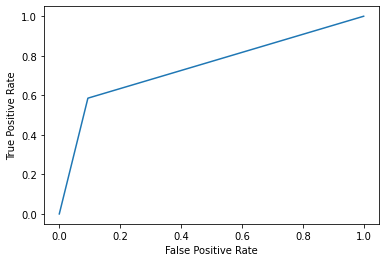

In [45]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

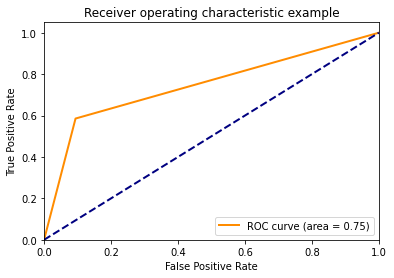

In [44]:
plt.figure()
lw = 2
plt.plot(
fpr, tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("employee churn rate")
plt.legend(loc="lower right")
plt.show()

Conclusion: there is a 83% possibility that 60% of the employees want to leave.